<a href="https://colab.research.google.com/github/abdn-cs3033-ai/practicals/blob/main/week03/tutorial2-search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS3033: Artificial Intelligence

## Tutorial 02: Search Algorithms

<h4>Prof. Felipe Meneguzzi</h4>

In order to run this tutorial, you need to download the auxiliary files from Github into your notebook, which we do with Jupyter's shell commands (if you downloaded the entire repo, the code below is not necessary).

In [ ]:
try:
    import google.colab
    print("We are in Google colab, we need to clone the repo")
    !git clone https://github.com/abdn-cs3033-ai/practicals.git
    %cd practicals/week03
except:
    print("Not in colab")

Not in colab


## Sliding Puzzle

The [Sliding Puzzle](https://en.wikipedia.org/wiki/Sliding_puzzle), also called **sliding block puzzle** is a combination puzzle that challenges a player to slide (frequently flat) pieces along certain routes (usually on a board) to establish a certain end-configuration. The pieces to be moved may consist of simple shapes, or they may be imprinted with colours, patterns, sections of a larger picture (like a jigsaw puzzle), numbers, or letters. Figure 1 shows an example of a set of legal moves.

Rules of this game are very simple—we slide (←, →, ↑, ↓) tiles to reach the final state in which all numbers are in order with ‘1’ in the top left corner of the board.

In [ ]:
from IPython.display import Image

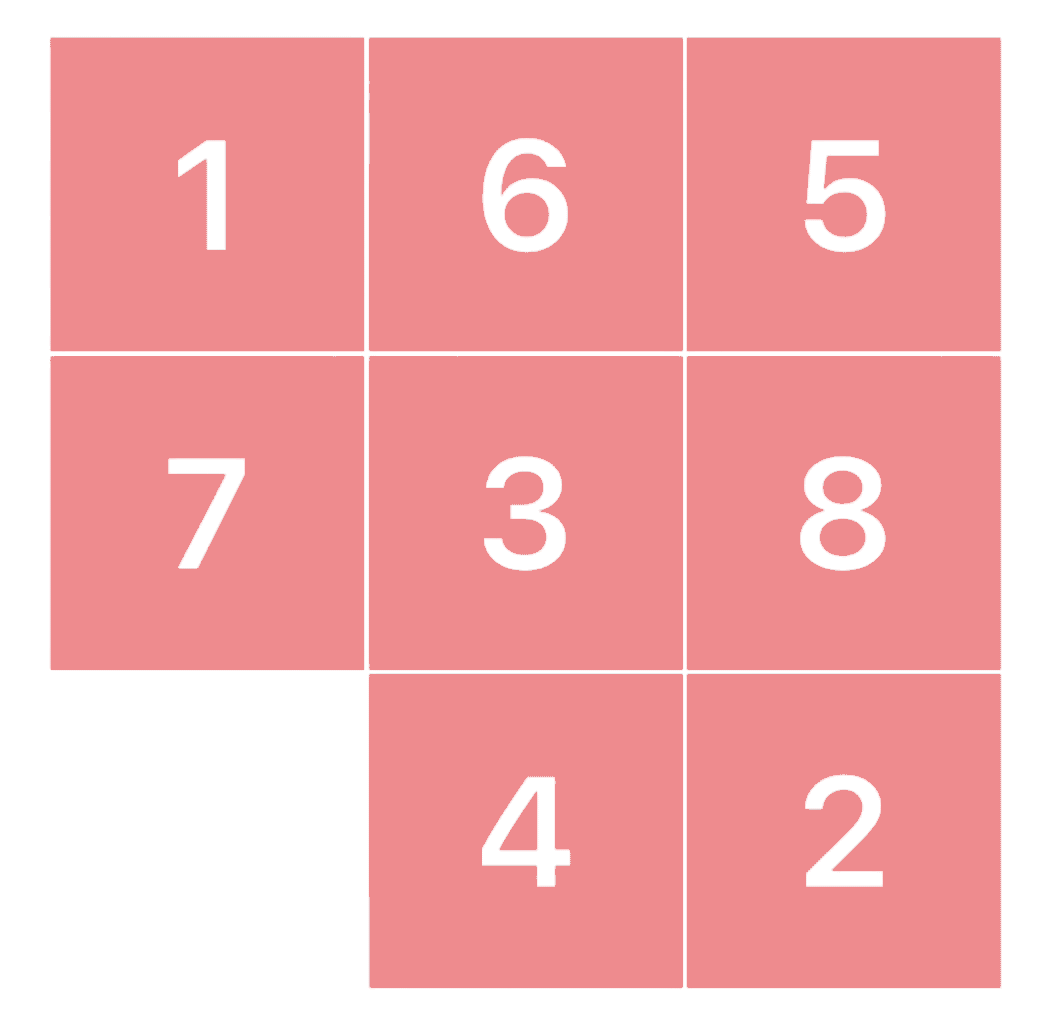

In [ ]:
Image(open('img/example.gif','rb').read(), width=200)

Figure 1: A sequence of valid moves for sliding-puzzle's navigation problem

# Overview

For this tutorial assignment, you will implement the $A^{*}$ heuristic search algorithm to solve instances of the sliding blocks problem. Given a board state, find a combination of moves that leads to the final state. As an informed search method, $A^{*}$, relies on a heuristic distance function in order to efficiently prune the state space and speed up the search tree expansion towards the solution. In class, we saw two possible heuristics that can be applied to this problem, but in this assignment, we will focus on the Manhattan Distance Heuristic. This heuristic consists of distance in orthogonal movements between the block and its desired destination.

## Implementation

Our implementation borrows heavily from [AIMA-Python](https://github.com/aimacode/aima-python), which we encourage you to consult once you finish your implementation.

### Problems and Nodes

We start by defining the abstract class for a `Problem`; specific problem domains will subclass this. To make it easier for algorithms that use a heuristic evaluation function, `Problem` has a default `h` function (uniformly zero), and subclasses can define their own default `h` function.

We also define a `Node` in a search tree, and some functions on nodes: `expand` to generate successors; `path_actions` and `path_states`  to recover aspects of the path from the node.  

In [ ]:
import math
from queue import PriorityQueue
from notebook import pseudocode

class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds):
        self.__dict__.update(initial=initial, goal=goal, **kwds)

    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0

    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)


class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost


failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.


def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)


def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None):
        return []
    return path_states(node.parent) + [node.state]

### Search Algorithms

Recall the pseudocode from the AIMA Textbook. While it differs slightly from the one from the Lecture (which is arguably more detailed), it conveys broadly the same idea. Search consists of exploring a *frontier* data structure

In [ ]:
pseudocode('Tree-Search-and-Graph-Search')

### AIMA4e


__function__ GRAPH-SEARCH(_problem_) __returns__ a solution, or failure  
&emsp;_frontier_ &larr; a queue initially containing one path, for the _problem_'s initial state  
&emsp;_reached_ &larr; a table of {_state_: _node_}; initially empty  
&emsp;_solution_ &larr; failure  
&emsp;__while__  _frontier_ is not empty __and__ _solution_ can possibly be improved __do__  
&emsp;&emsp;&emsp;_parent_ &larr; some node that we choose to remove from _frontier_  
&emsp;&emsp;&emsp;__for__ _child_ __in__ EXPAND(_parent_) __do__   
&emsp;&emsp;&emsp;&emsp;&emsp;_s_ &larr; _child_.state  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ _s_ is not in _reached_  __or__ _child_ is a cheaper path than _reached_[_s_] __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_reached_[_s_] &larr; _child_  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;add _child_ to _frontier_  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__if__ _s_ is a goal and _child_ is cheaper than _solution_ __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_solution_  =  _child_  
&emsp;__return__ _solution_

---
__function__ EXPAND(_problem, parent_) __returns__ a list of nodes  
&emsp;_s_ &larr; _parent_.state  
&emsp;_nodes_ &larr; an empty list  
&emsp;__for__ _action_ __in__ _problem_.actions(_s_) __do__   
&emsp;&emsp;&emsp;_s'_ &larr; _problem_.result(_s_, _action_)  
&emsp;&emsp;&emsp;_cost_ &larr; _parent_.path-cost + _problem_.step-cost(_s, action, s')  
&emsp;&emsp;&emsp;add _node_ to _nodes_  
&emsp;__return__ _nodes_  

---
__Figure__ ?? In the GRAPH-SEARCH algorithm, we keep track of the best _solution_ found so far, as well as the states that we have already _reached_, and a _frontier_ of paths from which we will choose 
the next path to expand.
In any specific search algorithm, we specify (1) the criteria for ordering the paths in the frontier,
and (2) the procedure for determining when it is no longer possible to improve on a solution.

# TREE-SEARCH and GRAPH-SEARCH
## AIMA3e
__function__ TREE-SEARCH(_problem_) __returns__ a solution, or failure  
&emsp;initialize the frontier using the initial state of _problem_  
&emsp;__loop do__  
&emsp;&emsp;&emsp;__if__ the frontier is empty __then return__ failure  
&emsp;&emsp;&emsp;choose a leaf node and remove it from the frontier  
&emsp;&emsp;&emsp;__if__ the node contains a goal state __then return__ the corresponding solution  
&emsp;&emsp;&emsp;expand the chosen node, adding the resulting nodes to the frontier  

---
__function__ GRAPH-SEARCH(_problem_) __returns__ a solution, or failure  
&emsp;initialize the frontier using the initial state of _problem_  
&emsp;**_initialize the explored set to be empty_**  
&emsp;__loop do__  
&emsp;&emsp;&emsp;__if__ the frontier is empty __then return__ failure  
&emsp;&emsp;&emsp;choose a leaf node and remove it from the frontier  
&emsp;&emsp;&emsp;__if__ the node contains a goal state __then return__ the corresponding solution  
&emsp;&emsp;&emsp;**_add the node to the explored set_**  
&emsp;&emsp;&emsp;expand the chosen node, adding the resulting nodes to the frontier  
&emsp;&emsp;&emsp;&emsp;**_only if not in the frontier or explored set_**

---
__Figure__ ?? An informal description of the general tree\-search and graph\-search algorithms. The parts of GRAPH\-SEARCH marked in bold italic are the additions needed to handle repeated states.

### Our own search class

Below, we define a generic class for a search algorithm, which is the basis for the implementations you will do later on. Do not edit this particular class, as we will extend it by subclassing.

In [ ]:
class SearchAlgorithm:
    def init(self):
        # TODO initialize your attributes here if needed
        pass

    def solve(self, problem):
        # if plan found, otherwise returns None
        node = self.search(problem)
        if node is None:
            return None
        else:
            return path_actions(node)

    def search(self, problem):
        # TODO returns the search-tree node in which a
        # plan is found these are nodes from the search tree
        # If no plan found, return None
        return None

    def get_solvable(self, problem):
        # TODO returns True if plan found,
        # otherwise returns False
        return self.solve(problem) is not None

    def get_max_tree_height(self, problem):
        # TODO returns max tree height if plan found,
        # otherwise returns None
        return None

### Greedy Best First Search

In the class below, you will implement the greedy best first search (GBFS) algorithm on graphs. You will do this by translating the pseudocode from the lecture into python.

In [ ]:
class GreedyBestFirstSearch(SearchAlgorithm):
    def init(self):
        # TODO initialize your attributes here if needed
        pass

    def search(self, problem):
        # TODO This is where you should implement GBFS
        return None

    def get_solvable(self, problem):
        # TODO returns True if plan found,
        # otherwise returns False
        return self.solve(problem) is not None

    def get_max_tree_height(self, problem):
        # TODO returns max tree height if plan found,
        # otherwise returns None
        return 0

### A$^*$ Search

In the class below, you will implement the A Star (A$^*$) algorithm on graphs. You will do this by translating the pseudocode from the lecture into python.

In [ ]:
class AStarSearch(SearchAlgorithm):
    def init(self):
        # TODO initialize your attributes here if needed
        pass

    def search(self, problem):
        # TODO This is where you should implement A Star
        return None

    def get_solvable(self, problem):
        # TODO returns True if plan found,
        # otherwise returns False
        return self.solve(problem) is not None

    def get_max_tree_height(self, problem):
        # TODO returns max tree height if plan found,
        # otherwise returns None
        return 0

### 8 Puzzle Problems

![](https://ece.uwaterloo.ca/~dwharder/aads/Algorithms/N_puzzles/images/puz3.png)

A sliding tile puzzle where you can swap the blank with an adjacent piece, trying to reach a goal configuration. The cells are numbered 0 to 8, starting at the top left and going row by row left to right. The pieces are numebred 1 to 8, with 0 representing the blank. An action is the cell index number that is to be swapped with the blank (*not* the actual number to be swapped but the index into the state). So the diagram above left is the state `(5, 2, 7, 8, 4, 0, 1, 3, 6)`, and the action is `8`, because the cell number 8 (the 9th or last cell, the `6` in the bottom right) is swapped with the blank.

There are two disjoint sets of states that cannot be reached from each other. One set has an even number of "inversions"; the other has an odd number. An inversion is when a piece in the state is larger than a piece that follows it.

In [ ]:
from collections import defaultdict
from itertools import combinations
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(0, 1, 2, 3, 4, 5, 6, 7, 8)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal

    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]

    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)

    def h1(self, node):
        """The misplaced tiles heuristic."""
        return hamming_distance(node.state, self.goal)

    def h2(self, node):
        """The Manhattan heuristic."""
        # TODO This is where you implement Manhattan

    def h(self, node): return self.h2(node)


def hamming_distance(A, B):
    "Number of positions where vectors A and B are different."
    return sum(a != b for a, b in zip(A, B))


def inversions(board):
    "The number of times a piece is a smaller number than a following piece."
    return sum((a > b and a != 0 and b != 0) for (a, b) in combinations(board, 2))


def board8(board, fmt=(3 * '{} {} {}\n')):
    "A string representing an 8-puzzle board"
    return fmt.format(*board).replace('0', '_')

class Board(defaultdict):
    empty = '.'
    off = '#'
    def __init__(self, board=None, width=8, height=8, to_move=None, **kwds):
        if board is not None:
            self.update(board)
            self.width, self.height = (board.width, board.height)
        else:
            self.width, self.height = (width, height)
        self.to_move = to_move

    def __missing__(self, key):
        x, y = key
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return self.off
        else:
            return self.empty

    def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(row(y) for y in range(self.height))

    def __hash__(self):
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)

In [ ]:
# Some specific EightPuzzle problems

e1 = EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8))
e2 = EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0))
e3 = EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6))
e4 = EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1))
e5 = EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1))
e6 = EightPuzzle((1, 0, 2, 3, 4, 5, 6, 7, 8))
#e7 = EightPuzzle((1, 2, 3, 4, 5, 6, 0, 8, 7))

## Requirements

In [ ]:
!pip install timeout-decorator

## 7 Testing

You can automatically test your solution code with the unit tests below.

In [ ]:
# Test Cases and Solutions

e1_gbfs_sol = [6, 7, 4, 1, 0]
e2_gbfs_sol = [5, 2, 1, 4, 5, 2, 1, 0, 3, 4, 5, 2, 1, 4, 7, 6, 3, 0, 1, 2, 5, 4, 3, 6, 7, 8, 5, 2, 1, 0, 3, 6, 7, 4, 1, 2, 5, 4, 3, 0, 1, 4, 5, 2, 1, 4, 7, 8, 5, 2, 1, 4, 5, 8, 7, 4, 1, 0]
e3_gbfs_sol = [4, 5, 8, 7, 6, 3, 4, 5, 8, 7, 6, 3, 4, 7, 8, 5, 4, 3, 0, 1, 4, 3, 6, 7, 4, 1, 0, 3, 4, 7, 6, 3, 0]
e4_gbfs_sol = [5, 2, 1, 0, 3, 4, 7, 6, 3, 4, 5, 8, 7, 4, 1, 0, 3, 4, 1, 2, 5, 4, 1, 2, 5, 4, 3, 0, 1, 4, 5, 2, 1, 4, 7, 8, 5, 2, 1, 4, 5, 8, 7, 4, 1, 0]
e5_gbfs_sol = [8, 5, 4, 1, 0, 3, 4, 7, 8, 5, 2, 1, 4, 5, 8, 7, 4, 5, 2, 1, 0, 3, 6, 7, 8, 5, 4, 1, 2, 5, 4, 7, 6, 3, 0, 1, 2, 5, 4, 3, 6, 7, 4, 1, 0, 3, 4, 7, 6, 3, 4, 5, 8, 7, 6, 3, 4, 7, 8, 5, 4, 3, 0]
e6_gbfs_sol = [0]

e1_astar_sol = [6, 7, 4, 1, 0]
e2_astar_sol = [5, 4, 3, 6, 7, 8, 5, 2, 1, 4, 7, 6, 3, 4, 5, 8, 7, 6, 3, 4, 1, 0]
e3_astar_sol = [0, 3, 4, 5, 8, 7, 4, 5, 2, 1, 0, 3, 4, 1, 2, 5, 4, 7, 6, 3, 4, 1, 0]
e4_astar_sol = [3, 0, 1, 4, 7, 6, 3, 4, 5, 2, 1, 0, 3, 4, 5, 8, 7, 6, 3, 4, 5, 2, 1, 4, 3, 0]
e5_astar_sol = [4, 5, 8, 7, 4, 1, 0, 3, 6, 7, 4, 1, 0, 3, 6, 7, 4, 5, 2, 1, 4, 5, 8, 7, 4, 3, 0]
e6_astar_sol = [0]

In [ ]:
import unittest
import sys

try:
    from timeout_decorator import timeout
except:
    print ("""Oops! It looks like you don\'t have timeout-decorator installed. Please do so using the following command:
        pip install timeout-decorator""")
    sys.exit(0)


# ==========================================
# Test A*
# ==========================================

class Test_Search(unittest.TestCase):

    def solvable(self, algorithm, problem, expected):
        algorithm.solve(problem)
        #self.assertEqual(pathfinder.get_solvable(map), expected)
        var1 = algorithm.get_solvable(problem)
        var2 = expected
        if var1 != var2:
            print ("solvable failed! algorithm.get_solvable(map) is not equal to expected\n")

    def plan_match(self, algorithm, problem, moves):
        plan = algorithm.solve(problem)
        #self.assertEqual(plan, moves)
        var1 = plan
        var2 = moves
        if var1 != var2:
            print (f"plan_match failed! {plan} is not equal to {moves}\n")

    def max_tree_height(self, algorithm, problem, height):
        plan = algorithm.solve(problem)
        #self.assertEqual(pathfinder.get_max_tree_height(map), height)
        var1 = algorithm.get_max_tree_height(problem)
        var2 = height
        if var1 != var2:
            print (f"max_tree_height failed! {var1} is not equal to {height}\n")


    # =============
    # = Heuristic =
    # =============

    def test_heuristic(self):
        #self.assertEqual(pathfinder.heuristic(p1, p2),1)
        var1 = e1.h(Node(e1.initial))
        var2 = 5
        if var1 != var2:
            print(f"test_heuristic failed! {var1} is not equal to 5\n")

        var1 = e2.h(Node(e2.initial))
        var2 = 12
        if var1 != var2:
            print(f"test_heuristic failed! {var1} is not equal to 12\n")

        var1 = e3.h(Node(e3.initial))
        var2 = 11
        if var1 != var2:
            print(f"test_heuristic failed! {var1} is not equal to 11\n")

        var1 = e4.h(Node(e4.initial))
        var2 = 18
        if var1 != var2:
            print(f"test_heuristic failed! {var1} is not equal to 18\n")

        var1 = e5.h(Node(e5.initial))
        var2 = 19
        if var1 != var2:
            print(f"test_heuristic failed! {var1} is not equal to 19\n")

        var1 = e6.h(Node(e6.initial))
        var2 = 1
        if var1 != var2:
            print(f"test_heuristic failed! {var1} is not equal to 1\n")

    # ------------------------------------------
    # Trivial
    # ------------------------------------------

    @timeout(15)
    def test_trivial_plan_match(self):
        gbfs = GreedyBestFirstSearch()
        astar = AStarSearch()
        self.plan_match(gbfs, e6, e6_gbfs_sol)
        self.plan_match(astar, e6, e6_astar_sol)

    @timeout(15)
    def test_trivial_max_tree_height(self):
        gbfs = GreedyBestFirstSearch()
        astar = AStarSearch()
        self.max_tree_height(gbfs, e6, 1)
        self.max_tree_height(astar, e6, 1)

    @timeout(15)
    def test_easy_plan_match(self):
        gbfs = GreedyBestFirstSearch()
        astar = AStarSearch()
        self.plan_match(gbfs, e1, e1_gbfs_sol)
        self.plan_match(astar, e1, e1_astar_sol)

    @timeout(15)
    def test_easy_max_tree_height(self):
        gbfs = GreedyBestFirstSearch()
        astar = AStarSearch()
        self.max_tree_height(gbfs, e1, 5)
        self.max_tree_height(astar, e1, 5)

    @timeout(15)
    def test_medium_plan_match(self):
        gbfs = GreedyBestFirstSearch()
        astar = AStarSearch()
        self.plan_match(gbfs, e3, e3_gbfs_sol)
        self.plan_match(astar, e3, e3_astar_sol)

    @timeout(15)
    def test_medium_max_tree_height(self):
        gbfs = GreedyBestFirstSearch()
        astar = AStarSearch()
        self.max_tree_height(gbfs, e3, 33)
        self.max_tree_height(astar, e3, 23)

    @timeout(15)
    def test_hard_plan_match(self):
        gbfs = GreedyBestFirstSearch()
        astar = AStarSearch()
        self.plan_match(gbfs, e5, e5_gbfs_sol)
        self.plan_match(astar, e5, e5_astar_sol)

    @timeout(15)
    def test_hard_max_tree_height(self):
        gbfs = GreedyBestFirstSearch()
        astar = AStarSearch()
        self.max_tree_height(gbfs, e5, 63)
        self.max_tree_height(astar, e5, 27)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)
    #unittest.main()



.........
----------------------------------------------------------------------
Ran 9 tests in 0.002s

OK


max_tree_height failed! 0 is not equal to 5

max_tree_height failed! 0 is not equal to 5

plan_match failed! None is not equal to [6, 7, 4, 1, 0]

plan_match failed! None is not equal to [6, 7, 4, 1, 0]

max_tree_height failed! 0 is not equal to 63

max_tree_height failed! 0 is not equal to 27

plan_match failed! None is not equal to [8, 5, 4, 1, 0, 3, 4, 7, 8, 5, 2, 1, 4, 5, 8, 7, 4, 5, 2, 1, 0, 3, 6, 7, 8, 5, 4, 1, 2, 5, 4, 7, 6, 3, 0, 1, 2, 5, 4, 3, 6, 7, 4, 1, 0, 3, 4, 7, 6, 3, 4, 5, 8, 7, 6, 3, 4, 7, 8, 5, 4, 3, 0]

plan_match failed! None is not equal to [4, 5, 8, 7, 4, 1, 0, 3, 6, 7, 4, 1, 0, 3, 6, 7, 4, 5, 2, 1, 4, 5, 8, 7, 4, 3, 0]

test_heuristic failed! None is not equal to 5

test_heuristic failed! None is not equal to 12

test_heuristic failed! None is not equal to 11

test_heuristic failed! None is not equal to 18

test_heuristic failed! None is not equal to 19

test_heuristic failed! None is not equal to 1

max_tree_height failed! 0 is not equal to 33

max_tree_height fa